In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pylab as plt

from tensorflow.keras import layers

In [3]:
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
(training_set, validation_set), dataset_info = tfds.load("tf_flowers", as_supervised=True, with_info=True,
                                                         split=["train[70%:]", "train[:70%]"])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\JEANNOEL\tensorflow_datasets\tf_flowers\3.0.1.incompleteVRIMPZ\tf_flowers-train.tfrecord*..…

Dataset tf_flowers downloaded and prepared to C:\Users\JEANNOEL\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)

print(f"num classes: {num_classes}")
print(f"num training examples: {num_training_examples}")
print(f"num validation examples: {num_validation_examples}")

num classes: 5
num training examples: 1101
num validation examples: 2569


In [8]:
for ex in training_set.take(5):
    print(f"shape: {ex[0].shape}, label: {ex[1]}")

shape: (240, 320, 3), label: 4
shape: (333, 500, 3), label: 0
shape: (333, 500, 3), label: 1
shape: (284, 320, 3), label: 3
shape: (333, 500, 3), label: 0


In [9]:
IMAGE_RES = 299


def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label


BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [10]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [11]:
feature_extractor.trainable = False

In [13]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
EPOCHS = 6

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
35/35 [==============================] - 141s 4s/step - loss: 0.9501 - accuracy: 0.6567 - val_loss: 0.6388 - val_accuracy: 0.7735
Epoch 2/6
35/35 [==============================] - 139s 4s/step - loss: 0.5010 - accuracy: 0.8329 - val_loss: 0.4784 - val_accuracy: 0.8474
Epoch 3/6
35/35 [==============================] - 139s 4s/step - loss: 0.3731 - accuracy: 0.8919 - val_loss: 0.4306 - val_accuracy: 0.8610
Epoch 4/6
35/35 [==============================] - 136s 4s/step - loss: 0.3163 - accuracy: 0.9101 - val_loss: 0.3961 - val_accuracy: 0.8692
Epoch 5/6
35/35 [==============================] - 141s 4s/step - loss: 0.2703 - accuracy: 0.9273 - val_loss: 0.3720 - val_accuracy: 0.8766
Epoch 6/6
35/35 [==============================] - 142s 4s/step - loss: 0.2332 - accuracy: 0.9410 - val_loss: 0.3669 - val_accuracy: 0.8770


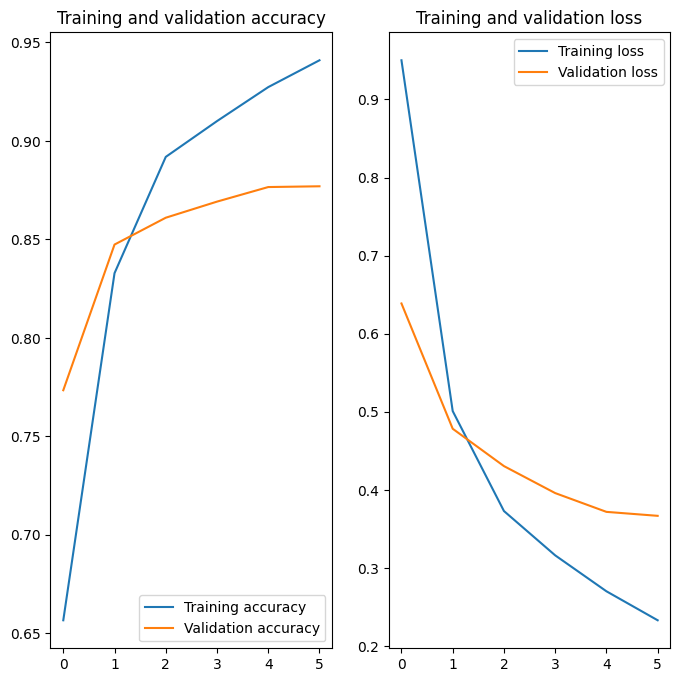

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and validation loss")
plt.show()

In [16]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [17]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_ids)
print(predicted_class_names)

1/1 [==============================] - 2s 2s/step
[4 0 4 2 2 3 1 4 2 2 3 0 0 2 0 3 2 2 0 0 4 3 0 4 2 3 2 2 3 0 2 1]
['roses' 'dandelion' 'roses' 'tulips' 'tulips' 'sunflowers' 'daisy'
 'roses' 'tulips' 'tulips' 'sunflowers' 'dandelion' 'dandelion' 'tulips'
 'dandelion' 'sunflowers' 'tulips' 'tulips' 'dandelion' 'dandelion'
 'roses' 'sunflowers' 'dandelion' 'roses' 'tulips' 'sunflowers' 'tulips'
 'tulips' 'sunflowers' 'dandelion' 'tulips' 'daisy']


In [18]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 0 4 2 2 0 1 4 2 2 3 0 0 2 3 3 2 2 0 0 4 3 0 4 2 3 2 2 3 0 2 1]
Predicted labels:  [4 0 4 2 2 3 1 4 2 2 3 0 0 2 0 3 2 2 0 0 4 3 0 4 2 3 2 2 3 0 2 1]


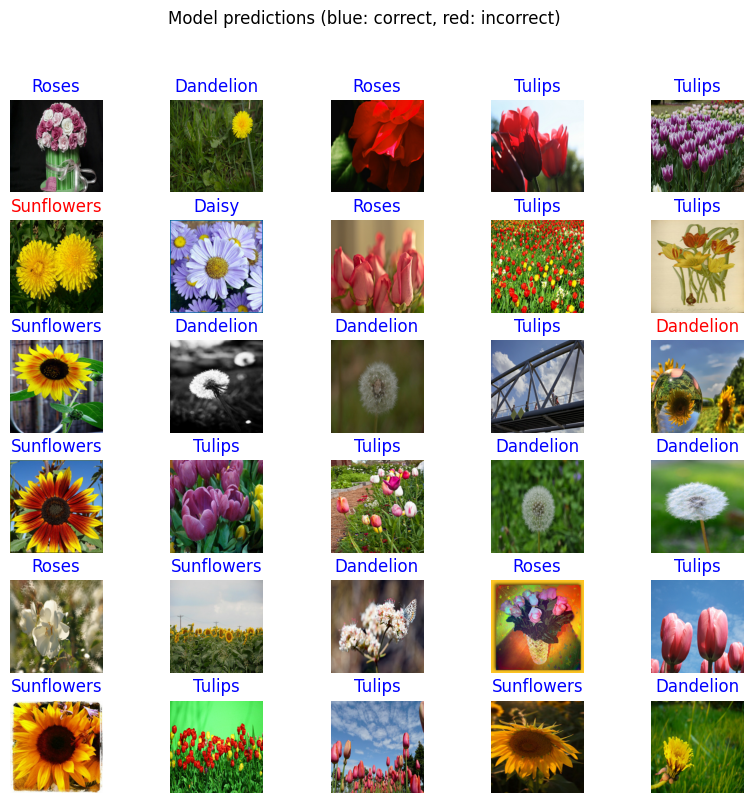

In [19]:
plt.figure(figsize=(10, 9))
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")